In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize

# Generalized Linear Models (GLMs)

>Question: What are the 3 componenents of a GLM?

*Answer here in **Markdown** and/aor $\LaTeX$*


In previous homework, we worked with retinal spiking data and tried to build a linear encoding model using least squares regression. You may recall the fit of this model was not great. In this problem you will build a Poisson GLM to compare its performance with the linear model.

Let's start by loading the file `rgcData_Uzzel04.mat` into Python, which contains 5 minutes of data from a retinal electrophysiology experiment. You'll find a matrix `stim`, which contains the values of 1D visual stimulus sampled at 120 Hz (the frame rate at which the luminance value of the screen changed) that is 144051 long. The values represent the light level of the screen (relative to a mean level of gray) at each moment in time.  

You'll also find two vectors of spike counts `spikes1` and `spikes2`, which contain the spike count of two retinal ganglion cells, measured in the same 120Hz time bins as the stimulus (so each entry in the vector is the number of spikes recorded in a 8.33 ms time bin).

This is *real* neural data, first published in [Uzzell & Chichilnisky (2004)](http://jn.physiology.org/content/92/2/780).

In [24]:
with open('314_glm_data.npy', 'rb') as f:
    data = np.load(f, allow_pickle=True).item()
data.keys()
stim = data['Stim']
spikes = data['SpikeCounts']
print('stim shape: ', stim.shape)
print('spikes shape: ', spikes.shape)

stim shape:  (144051,)
spikes shape:  (144051,)


Now we want to build a design matrix of the stimulus with 25 time lags. This means the first column of the matrix will be timelag t-24, then t-24,..., until t-0. 

>Construct a design matrix $X$ of size $144051 \times 25$ from the raw stimulus `stim` such that each row (corresponding to a time $t$) contains the 30 most recent values of the stimulus for the current time bin of the response (i.e., the stimulus values at times $t-24, t-23, \ldots , t-1, t-0$). For rows corresponding to stimulus times $t < 24$, simply set values for which there is no data (i.e. $t < 0$) to zero. An easy way to do this might be to start by making a length-144076 vector which contains the stimulus vector `stim` padded with zeros in the first 24 entries. Then you can use a simple `for` loop to build the design matrix.

>Once you construct the timelagged design matrix, add a column of ones to the end of the matrix.

In [13]:
win = 25
stim_padded = np.pad(stim, (win, 0), "constant", constant_values=0)
print(f"stim_padded shape: {stim_padded.shape}")
X = np.zeros((stim.size, win))

for i in range(stim.size):
    X[i] = stim_padded[i : (i+win)]

X = np.hstack((X, np.ones((stim.size, 1))))
print(f"X shape: {X.shape}")

stim_padded shape: (144076,)
X shape: (144051, 26)


> Visualize the first 50 rows of your design matrix using plt.imshow()

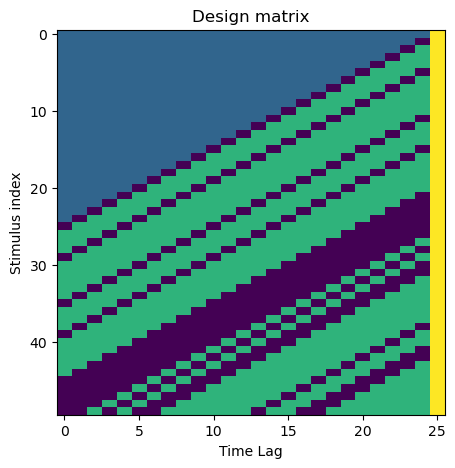

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.imshow(X[:50], aspect="auto")
axs.set_title("Design matrix")
axs.set_xlabel("Time Lag")
axs.set_ylabel("Stimulus index")
plt.show()


>Let's start by rebuilding our linear model using ordinary least squares regression (OLS). Use your design matrix $X$ and the neuron's responses in `spikes` to compute the least-squares regression solution for the weights (call this weights array `w_ols`).

Hint: We discussed how to compute the least-squares solution for the weights in class. You shouldn't need to use any additional functions beyond what we've already imported for you.

In [15]:
w_ols = np.linalg.inv(X.T @ X) @ X.T @ spikes

Now let's build our Poisson GLM. There is no closed form solution to this type of GLM like there is for OLS, so instead we have to use an optimizer to find the best weights. We want the optimizer to find the weights which produce the highest likelihood (MLE), $p(Y|X, \omega)$. Since most optimizers find a minima (we want a maxima), we will simply use the negative of the likelihood.

Recall that the probability defined by a poisson distribution is given by: $$p(Y=k) = \frac{\lambda^k e^{-\lambda}}{k!}$$

Where, $k$ is the number of observed spikes and $\lambda$ is the parameter defining the Poisson distribution. In our case, we can ignore the denominator, $k!$, as this just scales our likelihood (not relevant when optimizing).

$\lambda$ in this GLM will be defined as follows:
$$\begin{gather*} \lambda = e^r \\ r = X\vec{\omega} \end{gather*}$$

We will use log-likelihood as this is better for optimization. So, we can redefine our log-likelihood equation as follows (where log is natural-log):
$$\begin{align*} \log(p(Y|X, \omega)) & =  k\log(\lambda) - \lambda \end{align*}$$

This will give us a vector of the log-likelihood of each time point. To get the complete log-likelihood, we just need to take the sum of this vector. Finally, we'll take the negative of this value to get the negative log-likelihood (NLL) of our data.

>Complete the function below to calculate the NLL of our data. Do not change the name of the function or the arguments passed in.


In [16]:
def nll(w, X, y):
    r = X @ w   # fill in 
    lam = np.exp(r) # fill in
    ll = y * np.log(lam) - lam # fill in
    nll = -np.sum(ll) # fill in
    return nll

In [17]:
def neg_log_likelihood(theta, X, Y):
    return -np.sum(Y * (X @ theta) - np.exp(X @ theta))

The code cell below will find the optimal weights (`w_glm`) for your GLM given the function you just completed.
>Be sure to fill in X and y with your design matrix and spikes array, respectively

In [18]:
X = X
y = spikes
sta = (X.T@y)/y.size
w_glm = minimize(neg_log_likelihood, sta.squeeze(), args=(X, y), method='BFGS').x

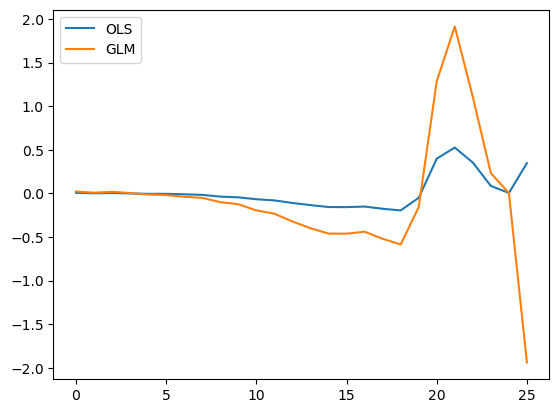

In [20]:
plt.plot(w_ols, label="OLS")
plt.plot(w_glm, label="GLM")
plt.legend()

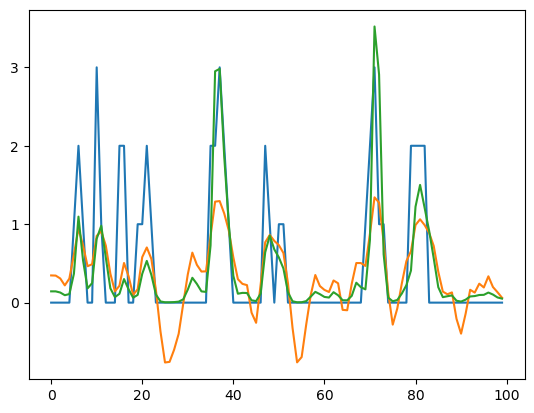

In [23]:
y_pred_ols = X @ w_ols
y_pred_glm = np.exp(X @ w_glm)
plt.plot(spikes[:100], label="True")
plt.plot(y_pred_ols[:100], label="OLS")
plt.plot(y_pred_glm[:100], label="GLM")